# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?







In [18]:
def prob_drunk_wp(priors,false_pr,true_pr,epochs=1,CI=0.95):
  
  # a hook to save which test the person is determined to be drunk on
  is_drunk_on=0
  for i in range(epochs):
    
    # bayisan test
    comp= 1-priors
    num=true_pr*priors
    den=num+(false_pr*comp)
    posterior=num/den
    
    # determine if the results allign with the CI
    if posterior >= CI:
      # if this person is already drunk then do nothing
      # otherwise record which was the first test they failed
      if is_drunk_on != 0:
        pass
      else:
        is_drunk_on=i+1
      # state that we think this person is drunk and why
      outcome=f"with a CI of {CI},\n\twith a p-value of {1-posterior},\n\tI suggest that this person is drunk.\n"
      outcome+=(f"person was deemed to be drunk after {is_drunk_on} tests\n")
    else:
      # state that we think this person is not drunk and why
      outcome=f"with a CI of {CI},\n\twith a p-value of {1-posterior},\n\tI suggest that this person is not drunk.\n"
    
    # print all stats in 'pretty' format
    print(f"For epoch:{i+1}\n\tpriors:{priors}\n\tfalse_positive_rate:{false_pr}\n\
\tTrue_positive_rate:{true_pr}\n\tcomplement:{comp}\n\tBayesain Stat:{posterior}\nConclusion:\n\t{outcome}")
    
    # update the priors with new information incase we are running a new test
    priors=posterior

  # return at the end of our epochs
  return ''

# init the question variables
priors=(1/1000)
false_prate=0.08
true_prate=1

# one run
print("Test 1: epochs 1")
prob_drunk_wp(priors,false_prate,true_prate,epochs=1)

# two runs
print("Test 2: epochs 2")
prob_drunk_wp(priors,false_prate,true_prate,epochs=2)

# five runs
print("Test 3: epochs 5")
prob_drunk_wp(priors,false_prate,true_prate,epochs=5)



Test 1: epochs 1
For epoch:1
	priors:0.001
	false_positive_rate:0.08
	True_positive_rate:1
	complement:0.999
	Bayesain Stat:0.012357884330202669
Conclusion:
	with a CI of 0.95,
	with a p-value of 0.9876421156697973,
	I suggest that this person is not drunk.

Test 2: epochs 2
For epoch:1
	priors:0.001
	false_positive_rate:0.08
	True_positive_rate:1
	complement:0.999
	Bayesain Stat:0.012357884330202669
Conclusion:
	with a CI of 0.95,
	with a p-value of 0.9876421156697973,
	I suggest that this person is not drunk.

For epoch:2
	priors:0.012357884330202669
	false_positive_rate:0.08
	True_positive_rate:1
	complement:0.9876421156697973
	Bayesain Stat:0.13525210993291495
Conclusion:
	with a CI of 0.95,
	with a p-value of 0.8647478900670851,
	I suggest that this person is not drunk.

Test 3: epochs 5
For epoch:1
	priors:0.001
	false_positive_rate:0.08
	True_positive_rate:1
	complement:0.999
	Bayesain Stat:0.012357884330202669
Conclusion:
	with a CI of 0.95,
	with a p-value of 0.987642115669797

''

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

In [0]:
# coping and pasting to get the df's set up
import numpy as np
import pandas as pd
from scipy import stats
# column headers
names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
# select my feature that i want to evaluate
subject='synfuels'
# init the datra frame from csv
df=pd.read_csv('/content/house-votes-84.data',names=names)
# make everything numbers
df=df.replace({'n':0,'y':1,'?':np.NaN})

In [0]:
# create a function to return some samples to me
def sample_data(df,frac=.5):
  s1=df.sample(frac=frac,random_state=200)
  s2=df.drop(s1.index)
  return s1, s2

# define a function that finds the CI's of a sample with a 95% confindence level
def CI(data, confidence=0.95):
  # find the mean of the data
  mean = np.mean(data)
  # find the size of the sample
  n = len(data)
  # calculate standard error
  stderr = stats.sem(data,nan_policy='omit')
  # Look up the t-statistic that contains 95% of possible sample means
  # within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  # calculate the margin of error
  margin_of_error = t * stderr
  # return the CI bounds and the mean as a tuple
  return np.array([mean - margin_of_error, mean, mean + margin_of_error])


In [0]:
#  pull some samples and assign them
# in this case im using an 80/20 split for
# my samples because io want to look at the difffrence
# in using diffrent sample sizes with the bayensin way and fequentist
# way
sample1,sample2=sample_data(df,frac=0.8)

# find the frequentist CI of the first sample
samp1_f_stats=CI(sample1[subject],confidence=0.95)
# find the frequentist CI of the second sample
samp2_f_stats=CI(sample2[subject],confidence=0.95)

s1=sample1[~np.isnan(sample1[subject])]
s2=sample2[~np.isnan(sample2[subject])]

# find the Bayesian approach CI of the sample1
samp1_b_stats ,_ ,_ =stats.bayes_mvs(s1[subject],alpha=0.95)
# find the Bayesian approach CI of the sample1
samp2_b_stats ,_ ,_ =stats.bayes_mvs(s2[subject],alpha=0.95)

In [54]:
print(samp1_b_stats)
a,b=samp1_b_stats
a

Mean(statistic=0.3502994011976048, minmax=(0.298873297530582, 0.40172550486462755))


0.3502994011976048

IndexError: ignored

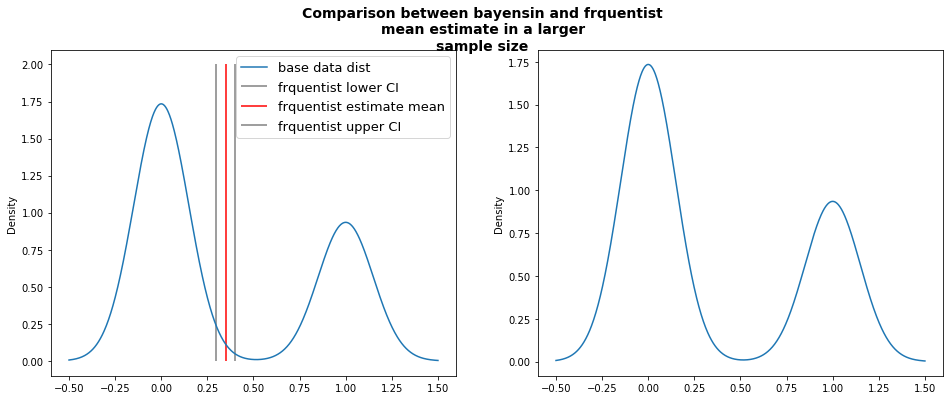

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[16,6]

######################################################################
##              first data sample (large)                           ##
######################################################################
# get my figure object
fig=plt.figure()
fig.suptitle("Comparison between bayensin and frquentist\nmean estimate in a larger\nsample size",
             fontsize=14,
             fontweight='bold')
# get my side by side subplots
ax0,ax1=fig.subplots(ncols=2)

#set eash suplot to my baseline data
sample1[subject].plot(ax=ax0 ,kind='kde',label='base data dist')
sample1[subject].plot(ax=ax1,kind='kde',label='base data dist')

# add frequntist CI to first plot
ax0.vlines(samp1_f_stats[0],
           0,2,
           color='grey',
           label="frquentist lower CI")
ax0.vlines(samp1_f_stats[1],
           0,2,
           color='red',
           label="frquentist estimate mean")
ax0.vlines(samp1_f_stats[2],
           ymin=0,ymax=2,
           color='grey',
           label="frquentist upper CI")
ax0.legend(markerscale=2,fontsize=13,fancybox=True)

# add bayensin CI to first plot
ax0.vlines(samp1_b_stats[1],
           0,2,
           color='grey',
           label="bayensin lower CI")
ax0.vlines(samp1_b_stats[0],
           0,2,
           color='red',
           label="bayensin estimate mean")
ax0.vlines(samp1_b_stats[2],
           ymin=0,ymax=2,
           color='grey',
           label="bayensin upper CI")
ax0.legend(markerscale=2,fontsize=13,fancybox=True)

plt.show()


######################################################################
##              second data sample (small)                          ##
######################################################################



### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).

In [0]:
# TODO - code!

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!